# Function

## New

In [1]:
import os
import PIL
import hashlib
import imagehash
import numpy as np
import matplotlib.pyplot as plt

class ImageDuplicate():
    def __init__(self, image_folder_path: str):
        try: # For development phase only
            get_ipython
            self.current_path = os.getcwd()
        except: # For production
            self.current_path = os.path.dirname(os.path.realpath(__file__))
        self.current_path = os.path.join(self.current_path, image_folder_path)

        self.image_in_folder_list = [file for file in os.listdir(self.current_path) if (file.endswith('.png')) | (file.endswith('.jpg'))]
        self.image_path_list = [os.path.join(self.current_path,image) for image in self.image_in_folder_list]
        self.hash_value_list = []

        self.similar_group_dict = {} # Group of image separate by hash value
        self.non_duplicate_list = [] # Select 1 image in each group
        self.duplicate_list = [] # The rest that not be selected in non_duplicate_list

    def find_exact(self):
        print(f'Using method: Exact Match (MD5)')

        for image_file in self.image_in_folder_list:
            image_fullpath = os.path.join(self.current_path,image_file)
            with open(image_fullpath, 'rb') as f:
                hash_value = hashlib.md5(f.read()).hexdigest()
            self.hash_value_list.append(hash_value)

        fast_check_duplicate = len(set(self.hash_value_list)) - len(self.hash_value_list)
        if fast_check_duplicate == 0:
            print('There is no duplicate image here.')
            return
        else:
            for image_name, hash_value in zip(self.image_in_folder_list,self.hash_value_list):
                if hash_value not in self.similar_group_dict:
                    self.similar_group_dict[hash_value] = [image_name]
                    self.non_duplicate_list.append(image_name)
                else:
                    self.similar_group_dict[hash_value] += [image_name]
                    self.duplicate_list.append(image_name)
                
            temp_similar_group_dict = self.similar_group_dict.copy()
            for (key,value) in temp_similar_group_dict.items():
                if len(value) == 1:
                    self.similar_group_dict.pop(key)

        group_key = list(np.arange(len(self.similar_group_dict)))
        self.similar_group_dict = dict(zip(group_key,list(self.similar_group_dict.values())))

        num_duplicate = len(self.duplicate_list)
        num_all = len(self.image_in_folder_list)
        percentage = np.round(num_duplicate/num_all * 100, 2)
        print(f'There are {num_duplicate} duplicated images out of {num_all} which is around {percentage} %.')

        return self.similar_group_dict, self.duplicate_list, self.non_duplicate_list

    def find_similar(self, hash_method:str='phash', distance:int=2, hash_size:int=16):
        print(f'Using method: {hash_method}\nAn accepted distance: {distance}\nHashing size: {hash_size}')

        for image_file in self.image_in_folder_list:
            image_fullpath = os.path.join(self.current_path,image_file)
            image = PIL.Image.open(image_fullpath)
            if hash_method == 'phash':
                hash_value = imagehash.phash(image, hash_size)
            elif hash_method == 'ahash':
                hash_value = imagehash.average_hash(image, hash_size)
            elif hash_method == 'dhash':
                hash_value = imagehash.dhash(image, hash_size)
            elif hash_method == 'whash':
                hash_value = imagehash.whash(image, hash_size)
            elif hash_method == 'crop_resistant_hash':
                """
                - No hashing size
                - Take too much time!! (as another hash algorithm use 250 ms but this one take 1 min for test dataset)
                """
                hash_value = imagehash.crop_resistant_hash(image)
            else:
                print('There are 4 methods here which is phash, ahash, dhash, whash')
            self.hash_value_list.append(hash_value)

        # It is recommend to use distance = 0 for time reduction.

        if distance == 0:
            fast_check_duplicate = len(set(self.hash_value_list)) - len(self.hash_value_list)
            if fast_check_duplicate == 0:
                print('There is no duplicate image here.')
                return
            else:
                for image_name, hash_value in zip(self.image_in_folder_list,self.hash_value_list):
                    if hash_value not in self.similar_group_dict:
                        self.similar_group_dict[hash_value] = [image_name]
                        self.non_duplicate_list.append(image_name)
                    else:
                        self.similar_group_dict[hash_value] += [image_name]
                        self.duplicate_list.append(image_name)
        else:
            temp_filename_list = []
            num = 0
            filename_hash_dict = dict(zip(self.image_in_folder_list,self.hash_value_list))
            temp_filename_hash_dict = dict(zip(self.image_in_folder_list,self.hash_value_list))
            sort_filename_hash_dict = sorted(filename_hash_dict)
            
            for file_first in sort_filename_hash_dict:
                if file_first in temp_filename_hash_dict:
                
                    temp_similar_list = []
                    temp_similar_list.append(file_first)
                    temp_filename_list.append(file_first)
                    temp_filename_hash_dict.pop(file_first)

                    image_first = filename_hash_dict[file_first]
                
                for file_second in sort_filename_hash_dict:
                    if file_second not in temp_filename_list:
                        image_second = filename_hash_dict[file_second]
                        hamming_distance = image_first - image_second
                        
                        if hamming_distance <= distance:
                            temp_similar_list.append(file_second)
                            temp_filename_list.append(file_second)

                if len(temp_similar_list) > 1:
                    self.similar_group_dict[num] = temp_similar_list

                    for _item in temp_similar_list[1:]:
                        self.duplicate_list.append(_item)

                    num = num + 1

            self.non_duplicate_list = [image for image in self.image_in_folder_list if image not in self.duplicate_list]

        return self.similar_group_dict, self.duplicate_list, self.non_duplicate_list

        num_duplicate = len(self.duplicate_list)
        num_all = len(self.image_in_folder_list)
        percentage = np.round(num_duplicate/num_all * 100, 2)

        print(f'There are {num_duplicate} duplicated images out of {num_all} which is around {percentage} %.')

In [2]:
class ShowImageDuplicate():
    def __init__(self, image_folder_path, group_of_duplicate_dict:dict):
        self.image_folder_path = image_folder_path
        self.group_of_duplicate_dict = group_of_duplicate_dict

        self.number_of_group = len(self.group_of_duplicate_dict)
        print(f'There are {self.number_of_group} of duplicate image.\nUse .show_group(group_number) or .show_all() for all group.')
    def show_all(self):
        """
        Show only first 5 images in each group
        """
        fig, axes = plt.subplots(nrows=self.number_of_group, ncols=5, figsize=(24, 24))
        for axis in axes.ravel():
            axis.set_axis_off()
        for group_number in np.arange(self.number_of_group):
            image_list = self.group_of_duplicate_dict[group_number]
            if len(image_list) > 5:
                image_list = image_list[:5]
            for image_number in np.arange(len(image_list)):
                image_path = os.path.join(self.image_folder_path,image_list[image_number])
                image = PIL.Image.open(image_path)
                axes[group_number,image_number].imshow(image)
        plt.tight_layout()

    def show_group(self, group_number):
        image_list = self.group_of_duplicate_dict[group_number]
        if len(image_list) < 5:
            num_col = len(image_list)
        else:
            num_col = 5
        num_row = int(len(image_list)/num_col)
        mod = len(image_list)%num_col
        if mod != 0:
            num_row = num_row + 1
        fig, axes = plt.subplots(nrows=num_row, ncols=num_col, figsize=(24, 10))
        for axis in axes.ravel():
            axis.set_axis_off()
        for index, image_name in enumerate(image_list):
            image_path = os.path.join(self.image_folder_path,image_name)
            image = PIL.Image.open(image_path)
            axes.ravel()[index].imshow(image)
        plt.tight_layout()

## Old

In [3]:
import os
import hashlib
from PIL import Image
import imagehash
import numpy as np
import matplotlib.pyplot as plt

class duplicate():
    #################################################################
    # init
    def __init__(self, image_folder_path):
        
        try:
            get_ipython
            self.current_path = os.getcwd() # For test function in .ipynb
        except:
            self.current_path = os.path.dirname(os.path.realpath(__file__)) # For .py
            
        self.current_path = os.path.join(self.current_path, image_folder_path)

        self.remove_filename_list = [] # List of similar image except original one
        self.similar_group_dict = {} # Group of similar image including original one

    #################################################################
    # Find    
    def find(self, mode = 'exact', distance = 0, phash_size = 16):
        
        num = 0
        filename_hash = dict()
        image_list = os.listdir(self.current_path)
        
        ###########################

        if mode == 'exact':

            hash_keys = dict()
            duplicate_group = dict()
            self.remove_filename_list = []

            for index, filename in enumerate(image_list):

                file_path = os.path.join(self.current_path, filename)

                if os.path.isfile(file_path):
                    with open(file_path, 'rb') as f:
                        filehash = hashlib.md5(f.read()).hexdigest()

                    filename_hash[filename] = filehash

                    if filehash not in hash_keys:
                        hash_keys[filehash] = index
                        
                    else:
                        self.remove_filename_list.append(filename)

            set_hash = set(filename_hash.values())

            for h in set_hash:
                duplicate_group[h] = [k for k in filename_hash.keys() if filename_hash[k] == h]

            for val in duplicate_group.values():
                if len(val) > 1:
                    self.similar_group_dict[num] = val
                    num = num + 1

            ############
            # print

            num_duplicate = len(self.remove_filename_list)
            num_all = len(filename_hash)
            percentage = np.round(num_duplicate/num_all * 100, 2)

            print('There are {} duplicated images from {} images which is around {} %.'.format(num_duplicate, num_all,percentage))

            return self.remove_filename_list, self.similar_group_dict

        ###########################

        if mode == 'similar':
            
            temp_filename_hash = dict()
            temp_filename_list = []
            self.remove_filename_list = []

            print('The accepted distance is {}'.format(distance))
            
            ############
            # Find phash
            for filename in image_list:

                file_path = os.path.join(self.current_path, filename)
                
                if os.path.isfile(file_path):
                    image_file = Image.open(file_path)                        
                    phash = imagehash.phash(image_file, hash_size = phash_size)
                    filename_hash[filename] = phash
                    temp_filename_hash[filename] = phash
            
            ############        
            # Find similarity between image using hamming distance (of phash)
            
            sort_filename_hash = sorted(filename_hash)
            
            for file_first in sort_filename_hash:
                
                if file_first in temp_filename_hash:
                
                    temp_similar_list = []
                    temp_similar_list.append(file_first)
                    temp_filename_list.append(file_first)
                    temp_filename_hash.pop(file_first)

                    image_first = filename_hash[file_first]
                
                for file_second in sort_filename_hash:
                    
                    if file_second not in temp_filename_list:
                        
                        image_second = filename_hash[file_second]
                        
                        hamming_distance = image_first - image_second
                        
                        if hamming_distance <= distance:
                            temp_similar_list.append(file_second)
                            temp_filename_list.append(file_second)

                if len(temp_similar_list) > 1:
                    self.similar_group_dict[num] = temp_similar_list

                    for _item in temp_similar_list[1:]:
                        self.remove_filename_list.append(_item)

                    num = num + 1
            
            ############
            # print

            num_duplicate = len(self.remove_filename_list)
            num_all = len(filename_hash)
            percentage = np.round(num_duplicate/num_all * 100, 2)

            print('There are {} similar images in distance from {} images which is around {} %.'.format(num_duplicate, num_all,percentage))

            return self.remove_filename_list, self.similar_group_dict

    #################################################################
    # Get           
    def get(self):
            
        return self.similar_group_dict, self.remove_filename_list
            

    #################################################################
    # Show    
    def show(self, max_sample_case = 1, max_sample_each_case = 1, figsize = (20,20)):
        
        try:
            get_ipython

            # nrow = 3
            # ncol = 3

            # fig, axs = plt.subplots(5, 5, figsize = figsize)

            for key_group in self.similar_group_dict:
                for filename in self.similar_group_dict[keygroup]:
                    file_path = os.path.join(self.current_path, filename)
                    image = Image.open(os.path.join(file_path))
        
                    # col = -1

                    # row = index%5
                    # if row == 0:
                    #     col = col + 1
                    # axs[row,col].imshow(np.array(image))
                    # axs[row,col].set_title('Predict as {}, Actual {}'.format(wrong[0], right))
                    # axs[row,col].grid(False)

            plt.show()

        except:
            print('Please run it in notebook')

    #################################################################
    # Remove    
    def remove_in_folder(self):
        for filename in self.remove_filename_list:
            file_path = os.path.join(self.current_path, filename)
            os.remove(file_path)

# Credit: https://medium.com/@urvisoni/removing-duplicate-images-through-python-23c5fdc7479e

# Test Function

In [6]:
pic_path = './image_data'

## New

In [26]:
%%time

exact_dups = ImageDuplicate(pic_path)
similar_group_dict, duplicate_list, non_duplicate_list = exact_dups.find_exact()

Using method: Exact Match (MD5)
There are 4 duplicated images out of 37 which is around 10.81 %.
CPU times: user 9.73 ms, sys: 7.75 ms, total: 17.5 ms
Wall time: 19.7 ms


In [27]:
%%time

sim_dups = ImageDuplicate(pic_path)
similar_group_dict, duplicate_list, non_duplicate_list = sim_dups.find_similar(hash_method = 'phash', distance = 20, hash_size = 16)

Using method: phash
An accepted distance: 20
Hashing size: 16
CPU times: user 200 ms, sys: 11.4 ms, total: 211 ms
Wall time: 213 ms


There are 5 of duplicate image.
Use .show_group(group_number) or .show_all() for all group.


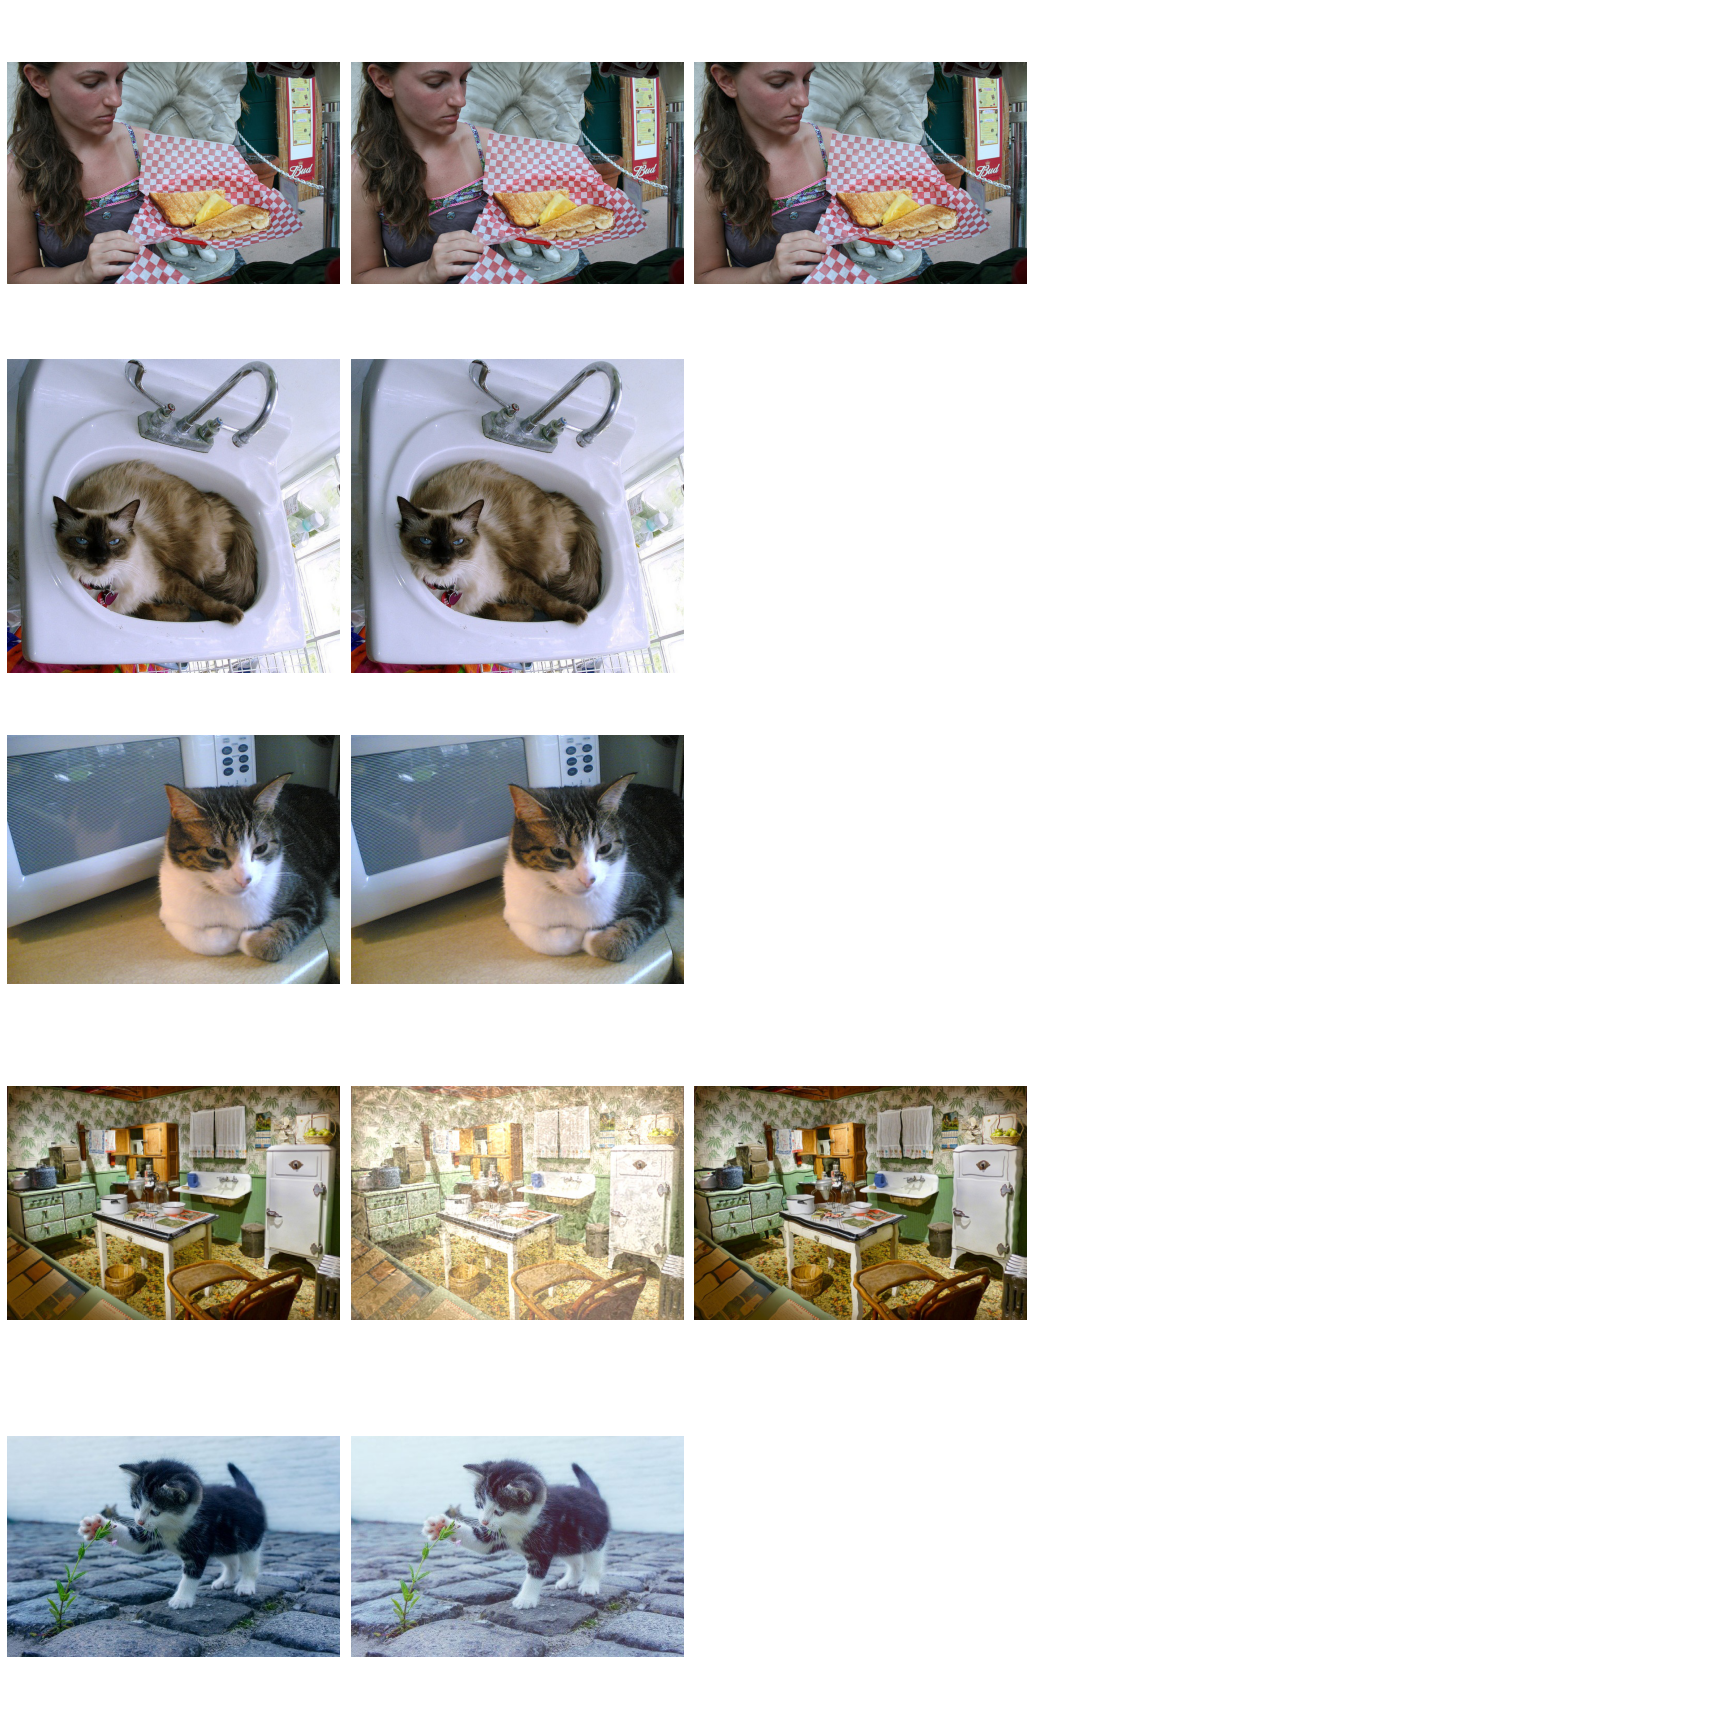

In [9]:
ShowImageDuplicate(pic_path,similar_group_dict).show_all()

There are 5 of duplicate image.
Use .show_group(group_number) or .show_all() for all group.


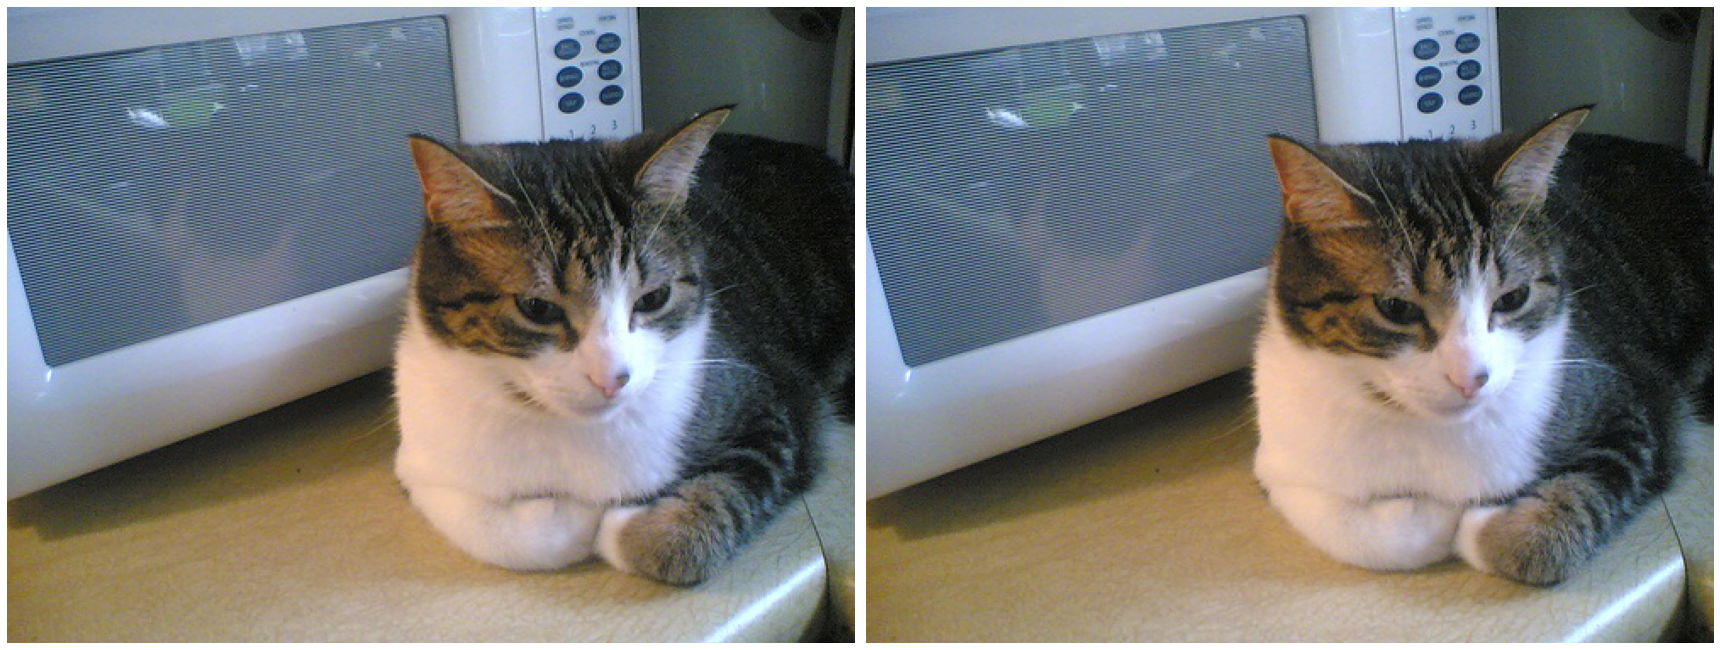

In [10]:
ShowImageDuplicate(pic_path,similar_group_dict).show_group(2)

## Old

In [11]:
my_dup = duplicate(pic_path)

In [12]:
%%time

remove_list, similar_group = my_dup.find(mode = 'exact')

There are 4 duplicated images from 37 images which is around 10.81 %.
CPU times: user 9.5 ms, sys: 6.79 ms, total: 16.3 ms
Wall time: 16.5 ms


In [13]:
remove_list

['q_copy1.jpg', 's.jpg', 'r.jpg', 'q.jpg']

In [14]:
similar_group

{0: ['r_copy.jpg', 'r.jpg'],
 1: ['s_copy.jpg', 's.jpg'],
 2: ['q_copy2.jpg', 'q_copy1.jpg', 'q.jpg']}

In [15]:
%%time

remove_list, similar_group = my_dup.find(mode = 'similar', distance = 0)

The accepted distance is 0
There are 4 similar images in distance from 37 images which is around 10.81 %.
CPU times: user 205 ms, sys: 13.8 ms, total: 219 ms
Wall time: 221 ms


In [16]:
remove_list

['q_copy1.jpg', 'q_copy2.jpg', 'r_copy.jpg', 's_copy.jpg']

In [17]:
similar_group

{0: ['q.jpg', 'q_copy1.jpg', 'q_copy2.jpg'],
 1: ['r.jpg', 'r_copy.jpg'],
 2: ['s.jpg', 's_copy.jpg']}

# Usage

## New

In [22]:
pic_path = './image_data'

In [23]:
from yellowduck.preprocessing.image import ImageDuplicate, ShowImageDuplicate

ModuleNotFoundError: No module named 'yellowduck.preprocessing'

In [24]:
exact_dups = ImageDuplicate(pic_path)
similar_group_dict, duplicate_list, non_duplicate_list = exact_dups.find_exact()

Using method: Exact Match (MD5)
There are 4 duplicated images out of 37 which is around 10.81 %.


There are 3 of duplicate image.
Use .show_group(group_number) or .show_all() for all group.


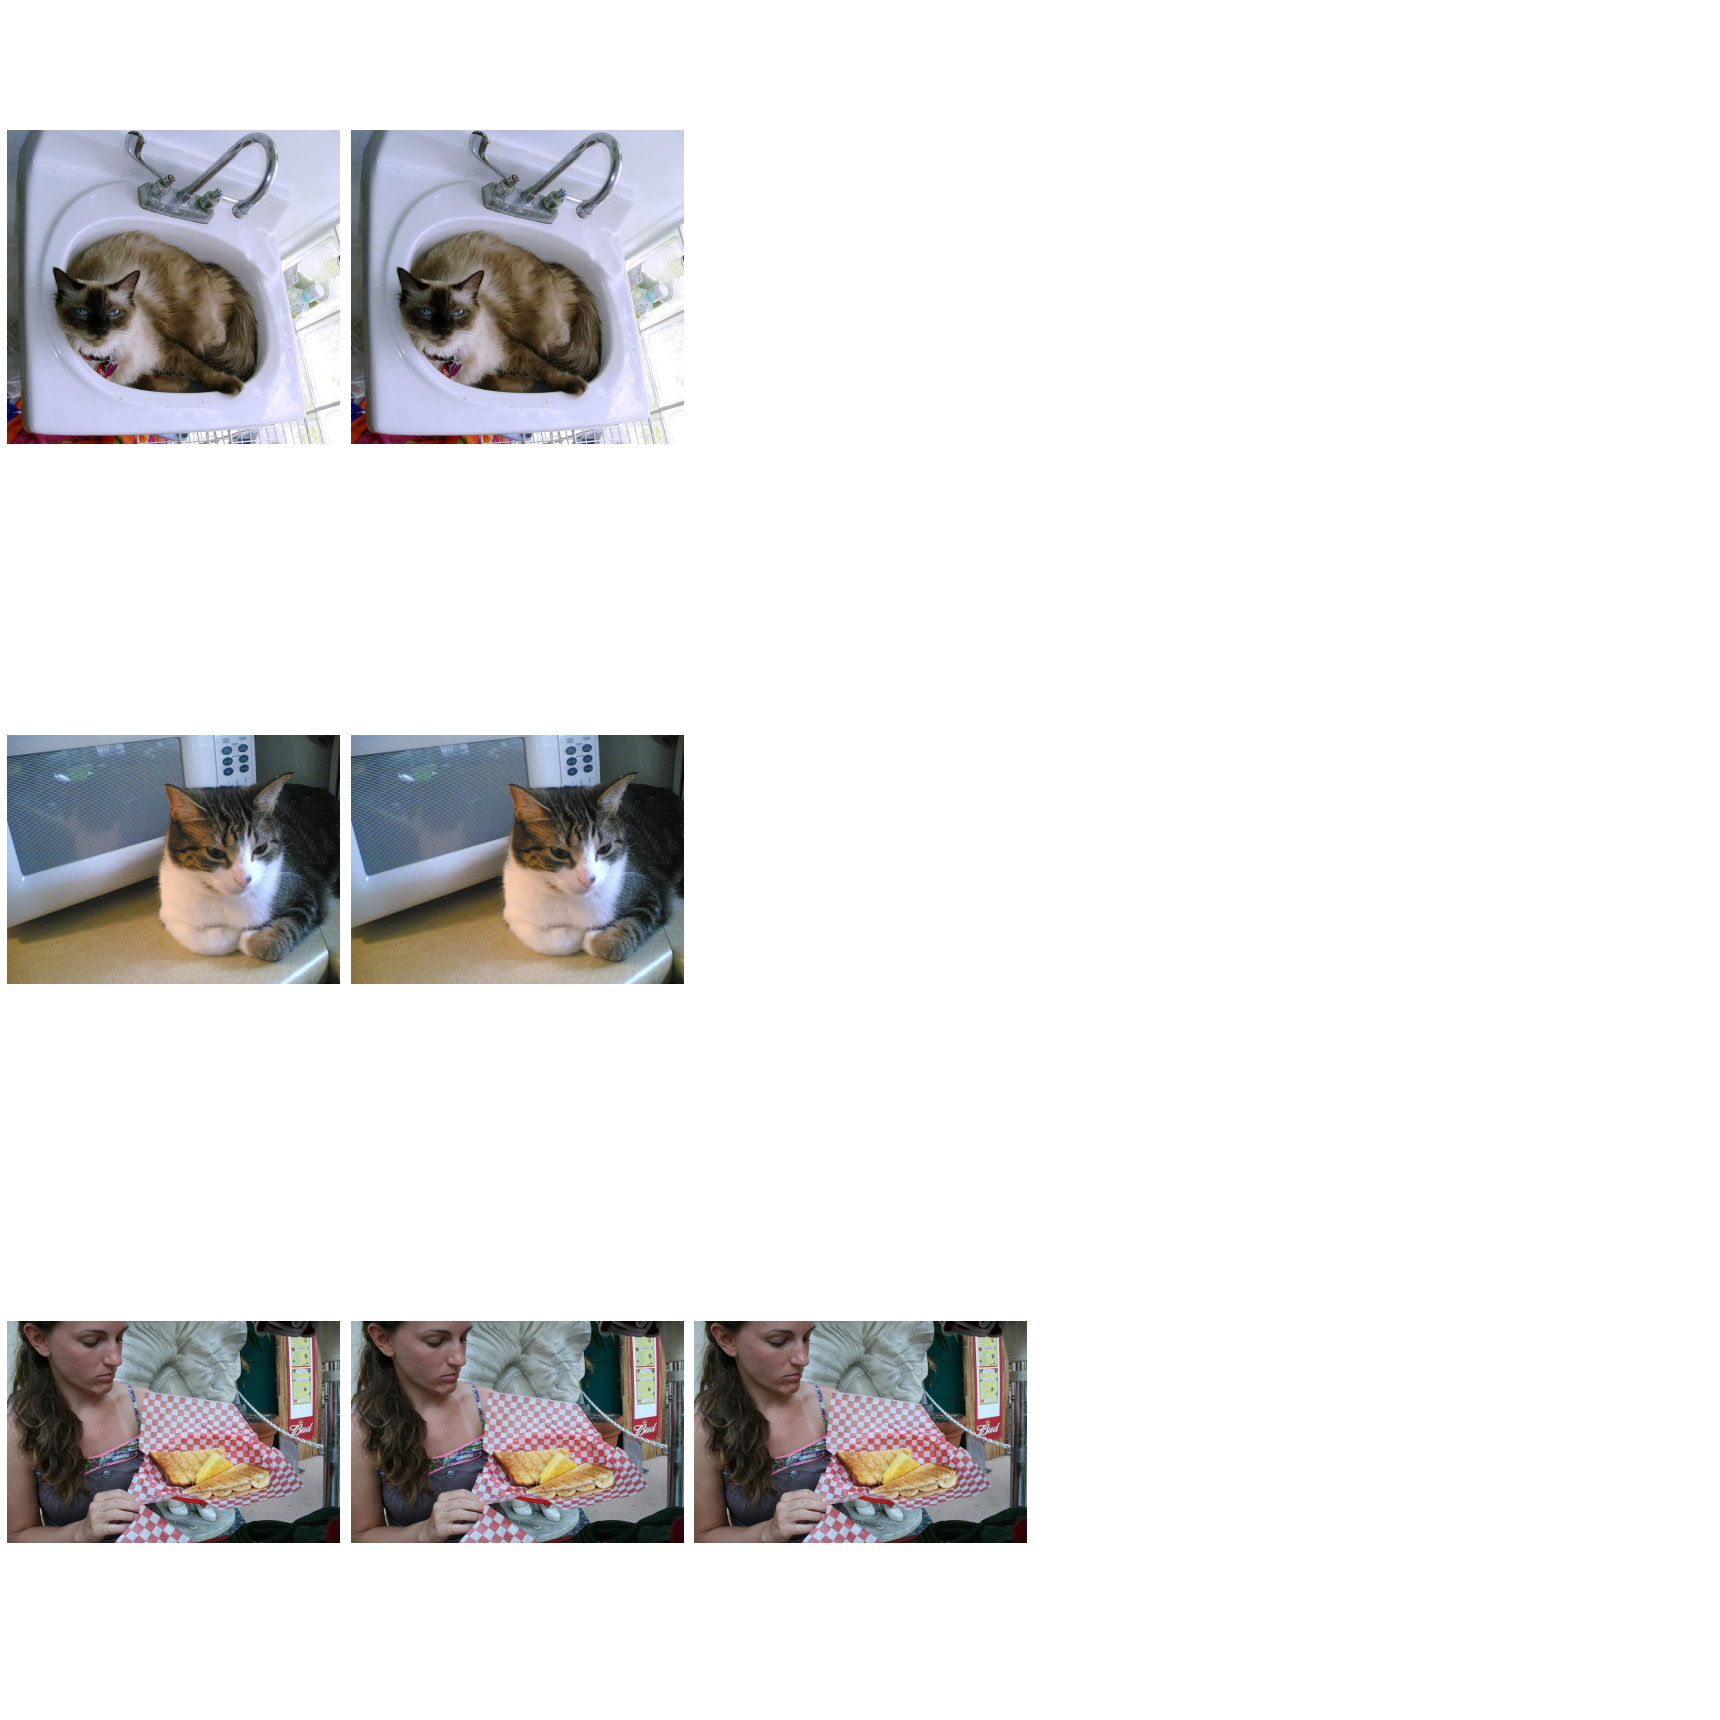

In [25]:
ShowImageDuplicate(pic_path,similar_group_dict).show_all()